- Goal: to build a time-series model using the enron email dataset to detect anomalies in email activity
- Model: time-series model using TensorFlow
- Python 3.6.10 using tensorflow-gpu
- Information about Enron obtained from https://www.theguardian.com/business/2006/jan/30/corporatefraud.enron

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
from email.parser import Parser
import datetime as dt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

Part 1: Preprocess the data
- Import the .csv file as a Pandas dataframe
- Extract the date from each email
- Extract the message_id from each email to use during aggregation
- Standardize the data for the model
- Plot the data on a line graph

In [2]:
# import data
with open('emails.csv') as f:
    data = pd.read_csv(f)

In [3]:
# extract date from the email and convert it to a datetime format
data['date'] = pd.to_datetime(data['message'].apply(lambda x: Parser().parsestr(x)['date']))

In [4]:
# remove the timezone info from the date to avoid errors later
data['date'] = data['date'].apply(lambda x: x.replace(tzinfo = None))

In [5]:
# very few emails before 1999 so only keep relatively recent data
# keep data until end of 2001 as this is when the Enron scandal concluded
data = data[(data['date'] >= dt.datetime(1999, 1, 1)) & (data['date'] <= dt.datetime(2001, 12, 31))]

In [6]:
# extract the message_id from each message so that we have an identifier we can count for aggregation
data['messageid'] = data['message'].apply(lambda x: Parser().parsestr(x)['message-id'])

In [7]:
# aggregate messages sent by day, count the number of identifiers per day
# rename the columns
agg = data[['date', 'messageid']].groupby(pd.Grouper(key = 'date', freq = 'D')).count().reset_index()
agg.columns = ['day', 'email_count']

In [8]:
# standardize the data
agg['email_count'] = StandardScaler().fit_transform(agg[['email_count']])

<AxesSubplot:xlabel='day'>

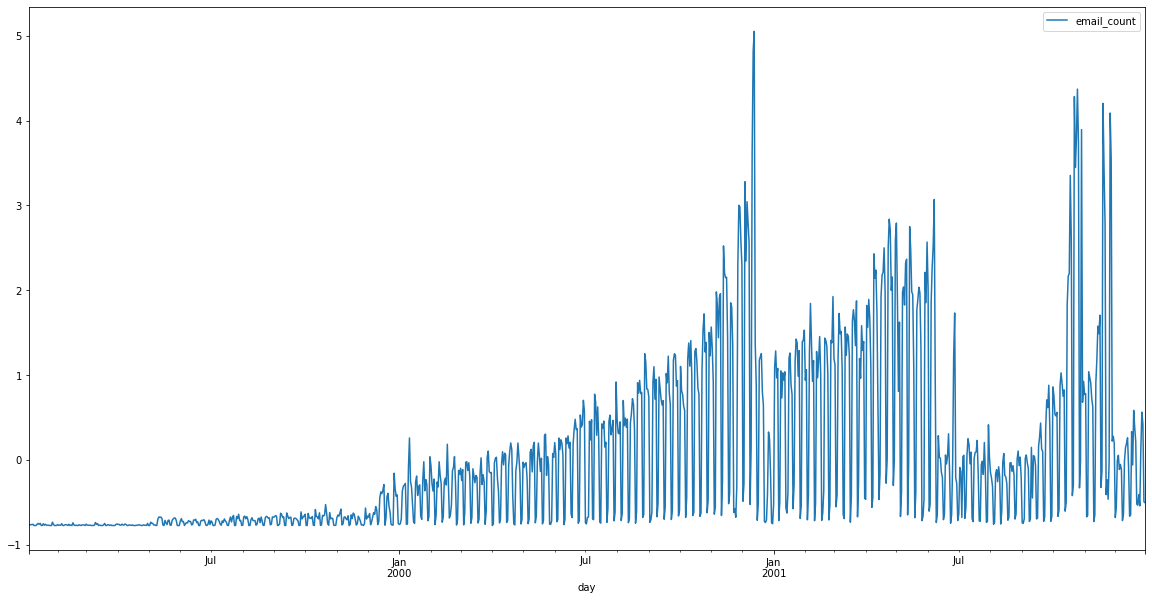

In [9]:
# plot the data to observe visual trends
agg.plot(x = 'day', y = 'email_count', kind = 'line', figsize = (20, 10))

Observations:
- Email seems to have been slowly adopted in the company starting mid 1999
- There are some short spikes of high levels of email usage; these appear to be anomalies

Part 2: Set up the model
- Split the data into a training and testing set (use Jan 1, 1999 - Jun 30, 2001 as the training set and Jul 1, 2001 - Dec 31, 2001 as the testing set); the second half of 2001 corresponds with known important dates in the Enron scandal
- Create a callback class to log the training and testing losses at the end of each epoch
- Set up the model and train it
- Analyze the training and testing losses

In [34]:
def create_dataset(dataset, lookback):
    """
    Function to split the data into training and testing sets.

    Arguments:
    - dataset: aggregated DataFrame with a 'day' column and 'email_count' column
    - lookback: the window to use for time-series prediction in days

    Returns training and testing x and y-values as numpy arrays.
    """

    x_train, x_test, y_train, y_test = [], [], [], []
    
    for i in range(lookback, dataset[(dataset['day'] <= dt.datetime(2001, 6, 30))].shape[0]):
        x_train.append(dataset['email_count'].iloc[i - lookback : i - 1])
        y_train.append([dataset['email_count'].iloc[i]])
    
    for j in range(i + 1, dataset.shape[0]):
        x_test.append(dataset['email_count'].iloc[j - lookback : j - 1])
        y_test.append([dataset['email_count'].iloc[j]])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))
    
    return x_train, x_test, y_train, y_test

In [35]:
# use 21 days as the lookback period and 
lookback = 7 * 3
x_train, x_test, y_train, y_test = create_dataset(agg, lookback)

In [36]:
# set up a simple RNN model using the dropout method to avoid overfitting to the training set
model = keras.models.Sequential([
    keras.layers.SimpleRNN(128, input_shape = (1, lookback - 1), dropout = 0.1),
    keras.layers.Dense(1)
])

In [37]:
# create a custom callback to record the training and testing loss at the end of each epoch
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs = {}):
        self.train_loss = []
        self.val_loss = []
    
    def on_epoch_end(self, batch, logs = {}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [38]:
# assign the callback to an object
history = myCallback()

In [39]:
# compile the model using MAPE as the loss function and ADAM as the optimizer with learning rate 0.01
model.compile(
    loss = tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer = tf.optimizers.Adam(learning_rate = 0.01)
)

In [40]:
# train the model using the computer's GPU
# train using batch processing rather than mini-batches or stochastic methods
with tf.device('/gpu:0'):
    model.fit(
        x_train,
        y_train,
        epochs = 500,
        batch_size = len(x_train),
        verbose = 1,
        callbacks = [history],
        validation_data = (x_test, y_test)
    )

=] - 0s 10us/sample - loss: 54.5821 - val_loss: 215.5347
Epoch 318/500
888/888 [==============================] - 0s 13us/sample - loss: 50.1967 - val_loss: 171.5227
Epoch 319/500
888/888 [==============================] - 0s 11us/sample - loss: 51.0901 - val_loss: 184.6251
Epoch 320/500
888/888 [==============================] - 0s 12us/sample - loss: 56.7569 - val_loss: 186.5584
Epoch 321/500
888/888 [==============================] - 0s 12us/sample - loss: 53.2405 - val_loss: 232.0713
Epoch 322/500
888/888 [==============================] - 0s 10us/sample - loss: 50.1164 - val_loss: 271.8326
Epoch 323/500
888/888 [==============================] - 0s 10us/sample - loss: 53.1144 - val_loss: 256.5456
Epoch 324/500
888/888 [==============================] - 0s 12us/sample - loss: 49.3490 - val_loss: 216.9026
Epoch 325/500
888/888 [==============================] - 0s 9us/sample - loss: 54.8131 - val_loss: 254.2366
Epoch 326/500
888/888 [==============================] - 0s 10us/sample 

<AxesSubplot:>

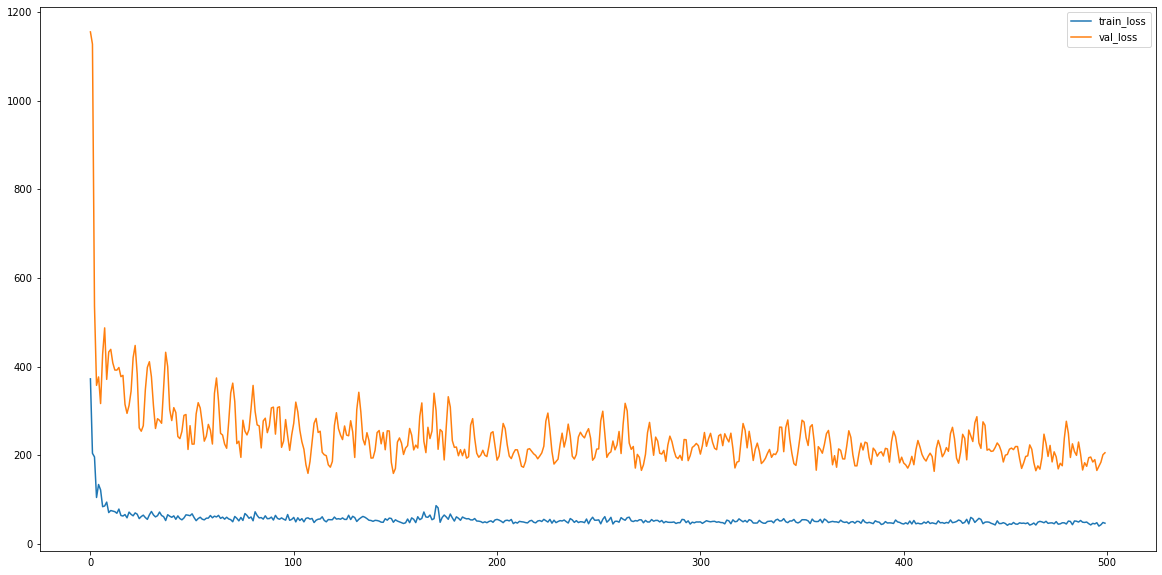

In [41]:
# create a dataframe that combines the training and validation losses and plot on a graph
losses = pd.DataFrame(data = zip(history.train_loss, history.val_loss))
losses.columns = ['train_loss', 'val_loss']
losses.plot(kind = 'line', figsize = (20, 10))

Observations:
- Both training and testing losses drop significantly in the first 100 epochs but stabilize thereafter
- Some variance as there is significant difference between the losses on the training and testing sets
- However, only 1.5 years of training data is available so this is expected

Part 3: Observe how well the model can predict on the training set
- Create a dataframe that combines the true number of emails (y) and the predicted number of emails (yhat)
- Plot both values on a line graph and analyze
- Create a rule to determine if a day has an anomaly
- Assess the effectiveness of the anomaly detection rule

In [50]:
# make predictions on the training set and create a dataframe to store the values
pred_train = model.predict(x_train)
pred_train_df = pd.DataFrame(pred_train)

<AxesSubplot:xlabel='day'>

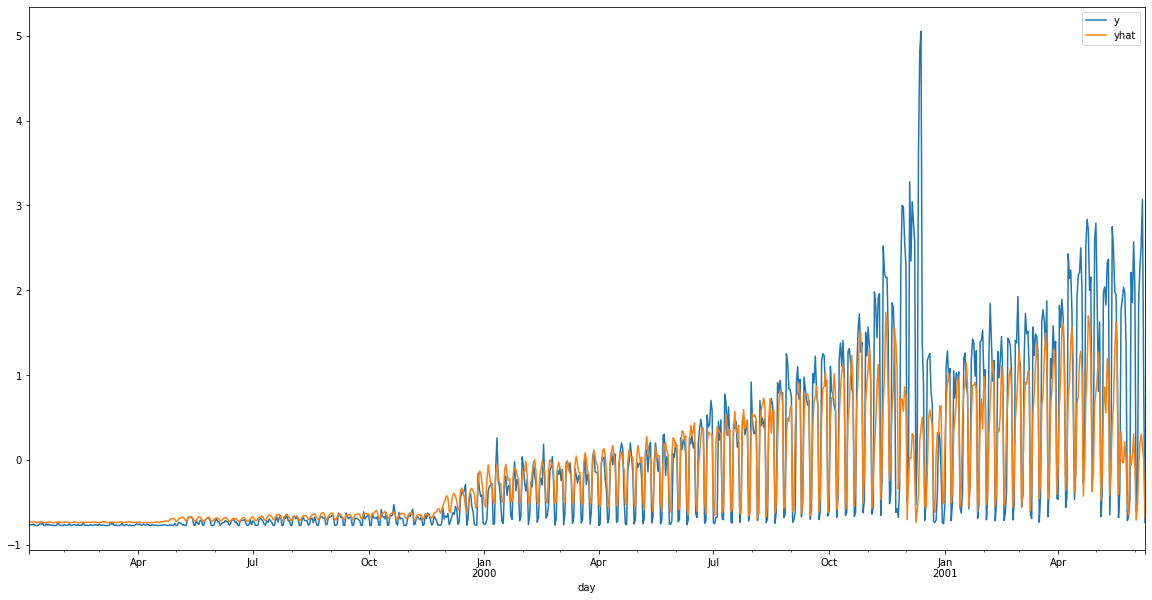

In [51]:
# combine y and yhat values for the training set
combined_train = agg[:len(x_train)].reset_index().drop(columns = 'index').merge(right = pred_train_df, how = 'left', left_index = True, right_index = True)

combined_train.columns = ['day', 'y', 'yhat']

combined_train.plot(x = 'day', y = ['y', 'yhat'], kind = 'line', figsize = (20, 10))

Observations:
- The model is able to capture the main fluctuations reasonably until just before Jan 2001
- The model is still able to capture the general trends after Jan 2001 but not as well

In [52]:
# create a rule to detrmine if a given date should be considered an anomaly
combined_train['diff'] = abs(combined_train['yhat'] - combined_train['y'])
combined_train['anomaly'] = combined_train['diff'].apply(lambda x: 1 if x > 2 else 0)

# print the number of anomlaies detected in the training set
print('Not an anomaly:\t\t{}'.format(combined_train[(combined_train['anomaly'] == 0)].shape[0]))
print('Anomaly:\t\t{}'.format(combined_train[(combined_train['anomaly'] == 1)].shape[0]))

Not an anomaly:		870
Anomaly:		18


<AxesSubplot:xlabel='day'>

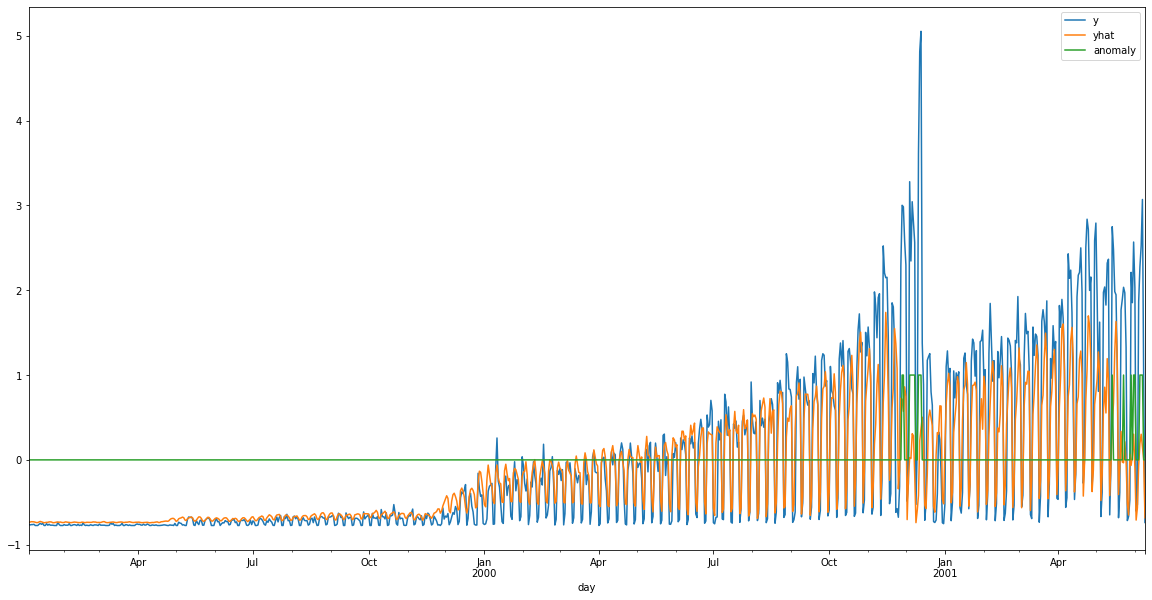

In [53]:
# plot the dates where the anomalies occur
combined_train.plot(x = 'day', y = ['y', 'yhat', 'anomaly'], kind = 'line', figsize = (20, 10))

Observations:
- Nov - Jan: Anomalies detected
    - Feb 5, 2001: Auditors discuss whether to retain Enron as a client amid concern over Enron's use of special partnerships to disguise debt
    - Likely high volume of emails sent before this announcement
- Feb 2001: Anomalies likely detected due to the above event
- Some noise detected near the end of the dataset

Part 4: Apply model to the rest of the data
- Create a dataframe that combines the true number of emails (y) and the predicted number of emails (yhat)
- Apply previously established anomaly detection rule and see if it corresponds to major events in Enron's history

In [54]:
# make predictions on the testing set and create a dataframe to store the values
pred_test = model.predict(x_test)
pred_test_df = pd.DataFrame(pred_test)

<AxesSubplot:xlabel='day'>

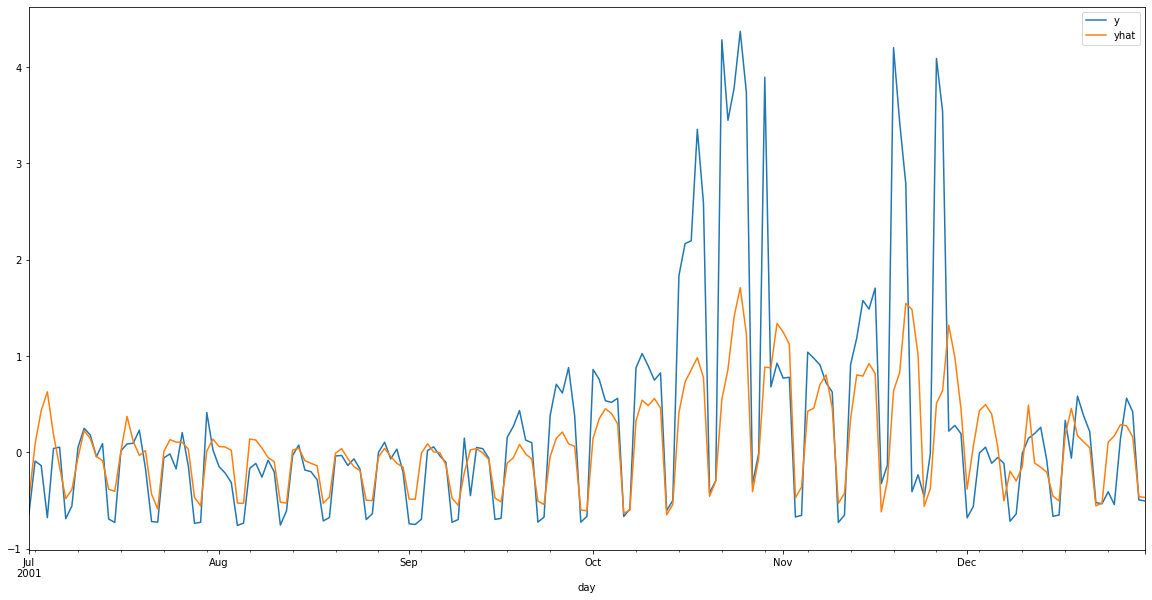

In [56]:
# combine y and yhat values for the testing set
combined_test = agg[-len(x_test):].reset_index().drop(columns = 'index').merge(right = pred_test_df, how = 'left', left_index = True, right_index = True)

combined_test.columns = ['day', 'y', 'yhat']

combined_test.plot(x = 'day', y = ['y', 'yhat'], kind = 'line', figsize = (20, 10))

Observations:
- The model seems to reasonably capture the patterns in the data, save for a few spikes

In [57]:
# apply the anomaly detection rule to the predicted values
combined_test['diff'] = abs(combined_test['yhat'] - combined_test['y'])
combined_test['anomaly'] = combined_test['diff'].apply(lambda x: 1 if x > 2 else 0)

# print the number of anomlaies detected in the testing set
print('Not an anomaly:\t\t{}'.format(combined_test[(combined_test['anomaly'] == 0)].shape[0]))
print('Anomaly:\t\t{}'.format(combined_test[(combined_test['anomaly'] == 1)].shape[0]))

Not an anomaly:		172
Anomaly:		11


<AxesSubplot:xlabel='day'>

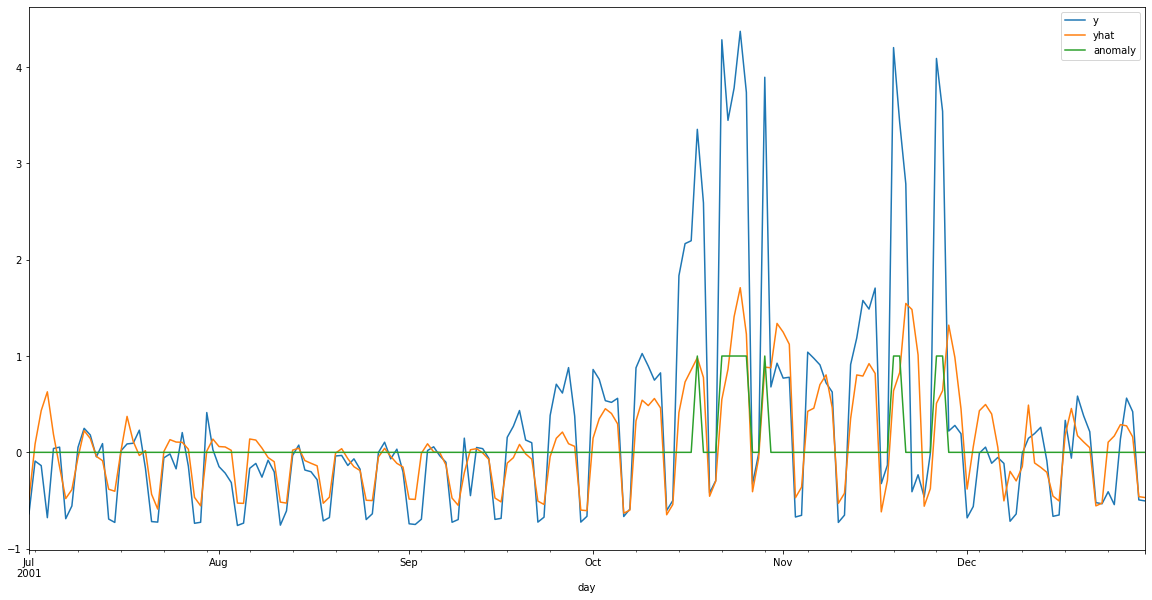

In [58]:
# plot the dates when the anomalies occur
combined_test.plot(x = 'day', y = ['y', 'yhat', 'anomaly'], kind = 'line', figsize = (20, 10))

Observations:
- Anomalies detected just before the beginning of November, this is just before Enron anounced that it overstated profits dating back to 1997 by $600M
- Anomalies detected just before the beginning of December, this is just before a few important events
    - November 29: SEC investigation is expanded to cover the CEO
    - December 2: Enron files for bankruptcy
    - December 4: Enron lays off 4,000 employees